# Cryogenic Pump Data Analysis

In [15]:
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sys

plt.rcParams['figure.figsize'] = 15,3
blue = '#1f77b4'
pd.set_option('precision', 2)

IS cryo has target temp 9 degrees. They come in [13,13.5] degrees. Motorspeed means IS.  
Upper temperature = T1 temperature.  
No heater usage, doesn't make temperature = failure.  
T1 has target temperature 65. Not lower, not higher.  
T2 wants it to be as cold as possible.  

Ernest's Theories:  
* T1 and T2 temperature crossing, dist to cooled-down should give info about displacer efficiency
* 

## Initializing the data
Round the nanoseconds to the nearest second.

In [2]:
url = "pump_data.csv"
dtype = {
    "unitsequence": int, # ID, negative is test, positive is production
    "uppervalue": float, # turbo vibrations
    "lowervalue": float,
    "rotorspeed": float, # turbo speed
    "motortemp": float, # turbo
    "controllertemp": float, # turbo
    "dcvoltage": float, # turbo
    "motorcurrent": float, # turbo
    "rotorposition0": str, # turbo, positions of the sensors that determine vibration
    "rotorposition1": str,
    "rotorposition2": str,
    "rotorposition3": str,
    "rotorposition4": str,
    "magcurrent0": float, # turbo balancing factors
    "magcurrent1": float, # 0-7 should all be symmetrical
    "magcurrent2": float,
    "magcurrent3": float,
    "magcurrent4": float,
    "magcurrent5": float,
    "magcurrent6": float,
    "magcurrent7": float,
    "magcurrent8": float, # last two are on top
    "magcurrent9": float,
    "sumcurrents": float, # sum of them
    "tmsactualtemp": float, # turbo heating system temperature. -80 means "NaN"
    "yh": str, # Alcatel turbo, replacement for `rotorposition0`.
    "yb": str,
    "z": float,
    # CRYO fields
    "motorspeed": str, # cryos
    "temp1": str, # cryos, target 65
    "temp2": str, # cryos, target 9/11
    "heater1": str,
    "heater2": str,
    "tcpressure": str, # thermocouple gauge pressure, cryo
    "timestamp": str,
    "currentregen": str, # letter codes
    "alarmstatusbits": str, # 
    "alertstatusbits": str,
    "valvestate": str
}
parse_dates = ['timestamp']
x = pd.read_csv(url, dtype=dtype, parse_dates=parse_dates)
x.loc[:,'timestamp'] = x.loc[:,'timestamp'].astype('datetime64[s]')
print("Shape:", x.shape)

Shape: (1218368, 39)


In [80]:
x[x["currentregen"] == '62']

,unitsequence,uppervalue,lowervalue,rotorspeed,motortemp,controllertemp,dcvoltage,motorcurrent,rotorposition0,rotorposition1,...,temp1,temp2,heater1,heater2,tcpressure,timestamp,currentregen,alarmstatusbits,alertstatusbits,valvestate
357067,-29686,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,340.8,311.5,0,100,2599.7,2018-06-29 13:18:23,62,NaN,NaN,NaN
357085,-29686,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,339.4,311.5,0,100,2604.2,2018-06-29 13:18:47,62,NaN,NaN,NaN
463135,-30107,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,321.3,331,100,0,0,2018-07-17 14:01:43,62,NaN,NaN,2
463878,-30039,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,316.9,329.3,100,50,0,2018-07-17 16:33:00,62,NaN,NaN,2
480881,-30105,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,320.7,329.6,100,50,0,2018-07-19 18:56:32,62,NaN,NaN,2
563656,-30115,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,324,334.6,100,0,0,2018-07-25 12:32:56,62,NaN,NaN,2
565978,-30115,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,319.1,332.4,100,0,0,2018-07-25 13:58:15,62,NaN,NaN,2
574173,-30115,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,318,331.6,100,0,0,2018-07-25 16:58:50,62,NaN,NaN,2
574206,-30115,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,326.1,335,100,0,0,2018-07-25 16:59:42,62,NaN,NaN,2
603816,-30107,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,319.3,331.8,100,0,0,2018-07-27 12:58:01,62,NaN,NaN,2


## Extract Dense Time Clusters for each Unit_Sequence

All the clusters for unit_sequence -18200
No. Clusters: 60
First Cluster


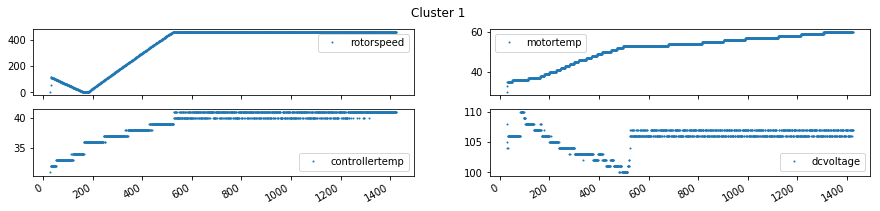

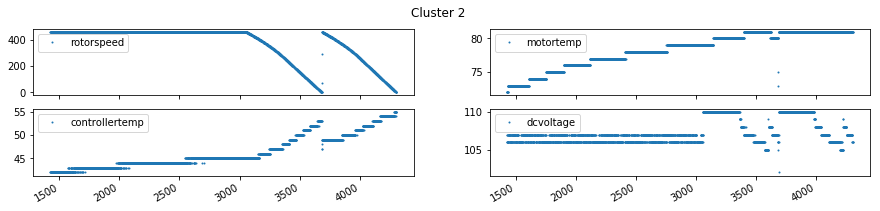

In [73]:
def get_clusters(unit_sequence_id):
    """
    Parameters:
        unit_sequence_id (int): the id of the pump (fx -18202).
        # col_name (str): the column to extract data for (fx "controllertemp")
    Returns:
        clusters (list(DataFrame)): the DataFrame clusters, ordered by time.
    """
    dfc = x[x["unitsequence"] == unit_sequence_id].sort_values("timestamp").copy()
    cluster = (dfc["timestamp"].diff() > pd.Timedelta(minutes=30)).cumsum()
    dfc = [v for k,v in dfc.groupby(cluster)]
    return dfc

def plot_cluster(cluster, title=None, col_names=["rotorspeed", "motortemp", "controllertemp", "dcvoltage"]):
    cluster.plot(y=col_names,
                subplots=True, layout=(2,2), marker='o', linestyle='None', color=blue,
                markersize=1)
    if title:
        plt.suptitle(title)
    plt.show()
    
def plot_cluster_magnets(cluster, title=None):
    magcurrents = ["magcurrent{}".format(i) for i in range(9)]
    cluster.plot(y=magcurrents,
                subplots=True, layout=(3,3), marker='o', linestyle='None', color=blue,
                markersize=1, figsize=(10,10))
    if title:
        plt.suptitle(title)
    plt.show()

clusters = get_clusters(-18200)
print("All the clusters for unit_sequence -18200")
print("No. Clusters:", len(clusters))
print("First Cluster")
for i, cluster in enumerate(clusters):
    plot_cluster(cluster, title="Cluster {}".format(i+1))
#     plot_cluster(cluster, title="Cluster {}".format(i+1), col_names=["temp1", "temp2", "heater1", "heater2"])
    if i == 1:
        break

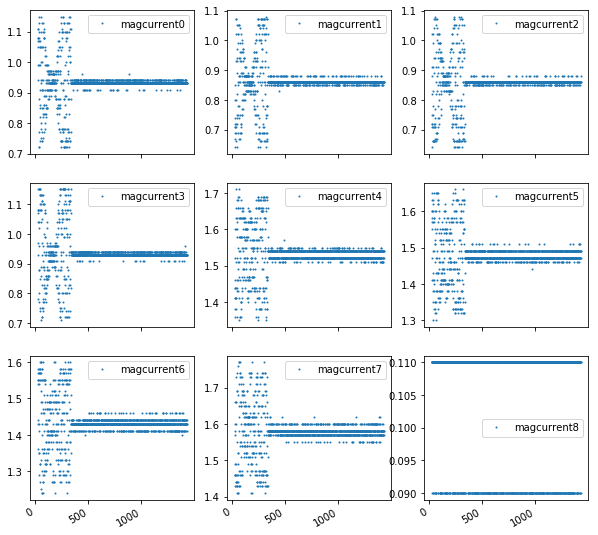

In [69]:
plot_cluster_magnets(clusters[0])

Excluding the first coefficient, which is the average value and skews the graph.


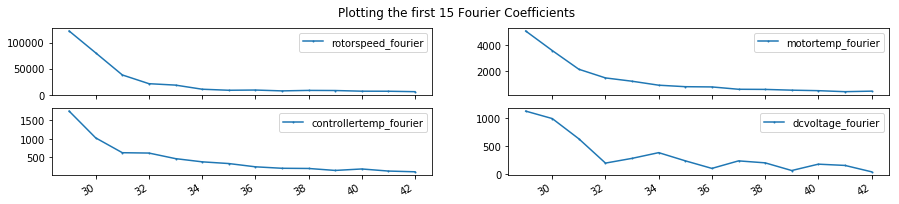

In [49]:
n_fourier_pts = 15
col_names = ["rotorspeed", "motortemp", "controllertemp", "dcvoltage"]
col_names_fourier = [n+"_fourier" for n in col_names]

def plot_fourier(cluster):
    print("Excluding the first coefficient, which is the average value and skews the graph.")
    x = np.arange(0, n_fourier_pts)
    for name in col_names:
        new_name = name + "_fourier"
        cluster.loc[:,new_name] = np.abs(scipy.fft(cluster[name]))
    cluster[1:n_fourier_pts].plot(y=col_names_fourier,
                                subplots=True, layout=(2,2), marker='o',
                                color=blue, markersize=1)
    plt.suptitle("Plotting the first {} Fourier Coefficients".format(n_fourier_pts))

plot_fourier(clusters[0])

## Gram Matrices to Compare Clusters Across Column Types

[[  0.  30.  31. 108.]
 [ 53.  33.  32. 105.]
 [113.  35.  32. 104.]
 ...
 [459.  60.  41. 107.]
 [462.  60.  41. 107.]
 [461.  60.  41. 107.]]
[[0.         0.01536867 0.02114173 0.02733107]
 [0.00360073 0.01690553 0.02182372 0.02657188]
 [0.00767703 0.01793011 0.02182372 0.02631881]
 ...
 [0.0311837  0.03073733 0.02796164 0.02707801]
 [0.03138752 0.03073733 0.02796164 0.02707801]
 [0.03131958 0.03073733 0.02796164 0.02707801]]


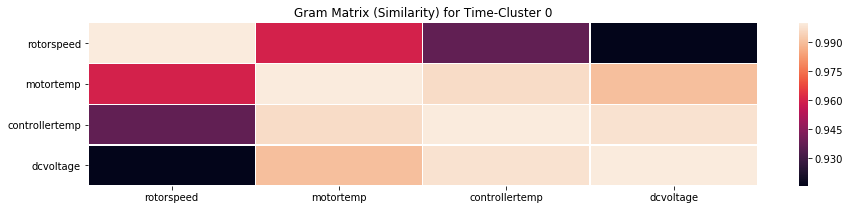

In [29]:
cluster = clusters[0]

def inner_product(cluster1, cluster2):
    """
    Returns the normalized sum of pointwise product of two Series, in [-1, 1].
    """
    c1s, c2s = cluster1.shape, cluster2.shape
    assert c1s == c2s, "Series must be same size. {} != {}".format(c1s, c2s)
    K = np.sqrt((cluster1**2).sum()) * np.sqrt((cluster2**2).sum()) # normalizing constant
    return (cluster1 * cluster2).sum() / K


cluster_matrix = cluster[col_names].values
print(cluster_matrix)
cluster_matrix = cluster_matrix / np.sqrt(np.sum(cluster_matrix**2, axis=0))
print(cluster_matrix)
gram_matrix = cluster_matrix.T @ cluster_matrix

g = sns.heatmap(gram_matrix, linewidth=0.5)
g.set_xticklabels(col_names)
g.set_yticklabels(col_names, rotation=0)
plt.title("Gram Matrix (Similarity) for Time-Cluster 0")
plt.show()

## Scatter Matrices to See Correlation

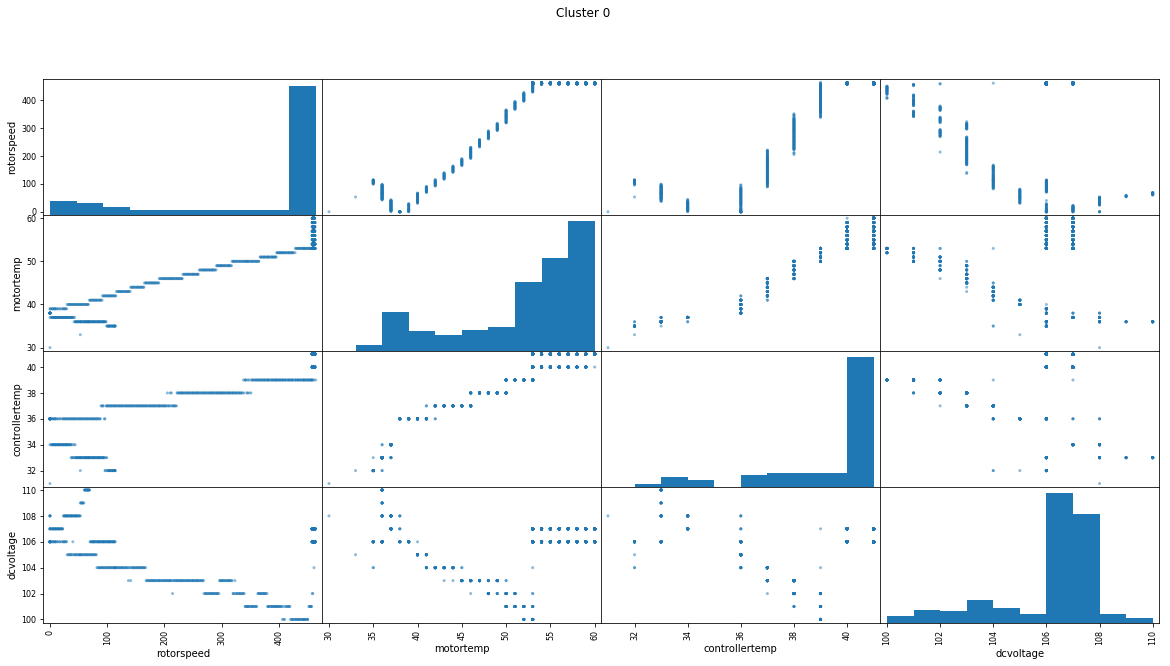

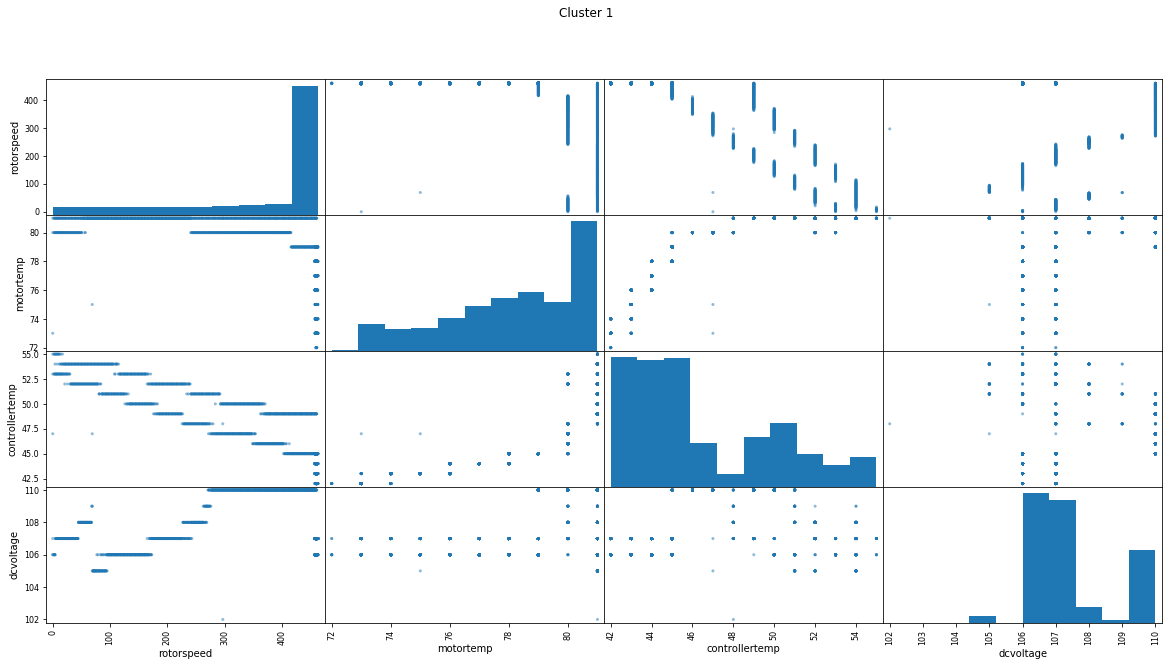

In [52]:
pd.plotting.scatter_matrix(cluster[col_names], figsize=(20,10))
plt.suptitle("Cluster 0")
plt.show()

pd.plotting.scatter_matrix(clusters[1][col_names], figsize=(20,10))
plt.suptitle("Cluster 1")
plt.show()

## K-Means Clustering with MSE
This is hard because clusters have different sizes, so we can't construct an (m,n) matrix.

In [11]:
def mse(c1, c2):
    return np.sqrt(((c1-c2)**2).sum())

# centroid, label = scipy.cluster.vq.kmeans2(clusters, 

## Theorizing that `unit_sequence` is the unique ID

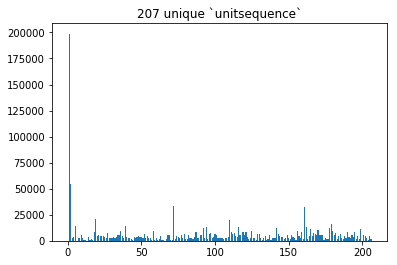

unitsequence ranges from -30997 to -9282
count ranges from 28 to 198742


In [12]:
unit_sequences = x["unitsequence"].unique()
count = np.array([
    x[x['unitsequence']==us].shape[0] for us in unit_sequences
])
n = len(count)
plt.bar(np.arange(n), count)
plt.title("{} unique `unitsequence`".format(n))
plt.show()
print("unitsequence ranges from {} to {}".format(unit_sequences.min(), 
                                                 unit_sequences.max()))
print("count ranges from {} to {}".format(count.min(), count.max()))

## All the Sparse Data

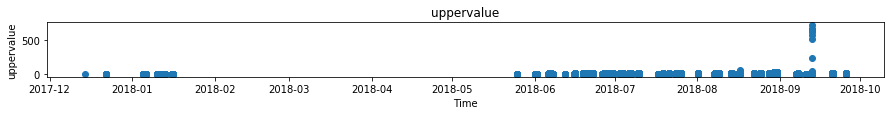

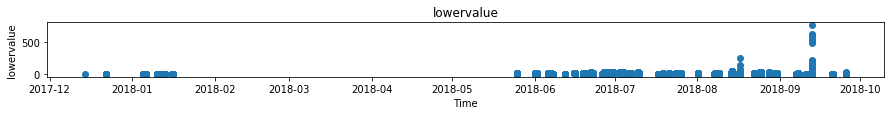

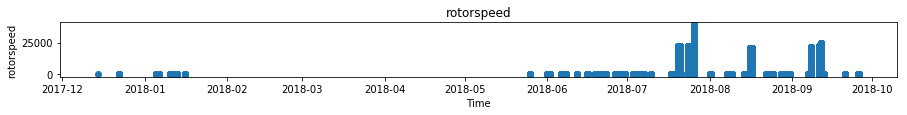

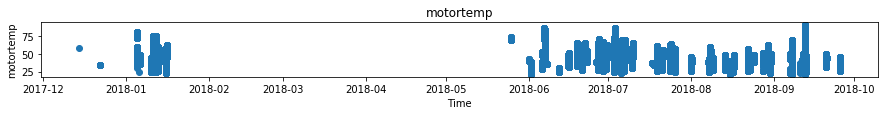

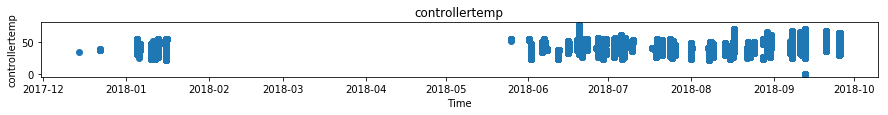

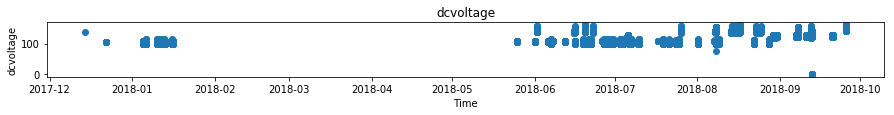

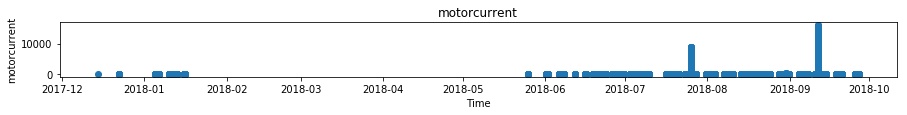

In [39]:
def plot_over_time(t,y,desc):
    fig = plt.figure(figsize=(15,1))
    ax = fig.add_subplot(111)
    ax.plot(t, y, 'o')
    ax.set_xlabel("Time")
    ax.set_ylabel(desc)
    ax.set_title(desc)
    plt.show()

n_timesteps, n_cols = x.shape
t = x["timestamp"].values
cols = ["uppervalue", "lowervalue", "rotorspeed","motortemp","controllertemp","dcvoltage","motorcurrent"]
for col in cols:
    plot_over_time(t,x[col].values,col)

In [46]:
def print_not_null_counts():
    all_cols = list(x.columns.values)
    counts = {}
    for col in all_cols:
        counts[col] = x[x[col].notnull()].shape[0]
    for col, val in sorted(counts.items()):
        print(col, counts[col])

def time_slice():
    dt1 = '2018-06-27 05:00:00'
    dt2 = '2018-06-27 06:00:00'
    dfs = df[(dt1 <= df['timestamp']) & (df['timestamp'] < dt2)]
    print("dfs:", dfs.shape)    

print_not_null_counts()

alarmstatusbits 0
alertstatusbits 0
controllertemp 362851
currentregen 802716
dcvoltage 354296
heater1 802716
heater2 802716
lowervalue 415652
magcurrent0 354296
magcurrent1 354296
magcurrent2 354296
magcurrent3 354296
magcurrent4 354296
magcurrent5 354296
magcurrent6 354296
magcurrent7 354296
magcurrent8 354296
magcurrent9 354296
motorcurrent 570796
motorspeed 558108
motortemp 362851
rotorposition0 52801
rotorposition1 52801
rotorposition2 52801
rotorposition3 52801
rotorposition4 52801
rotorspeed 415652
sumcurrents 354296
tcpressure 802716
temp1 802716
temp2 802716
timestamp 1218368
tmsactualtemp 354296
unitsequence 1218368
uppervalue 415652
valvestate 540316
yb 8555
yh 8555
z 68453
